In [114]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [169]:
df = pd.read_csv('/home/ro/PycharmProjects/My/Data setai/kickstarter-projects/ks-projects-201801.csv')

In [116]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [117]:
df.shape

(378661, 15)

In [118]:
df.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [119]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [120]:
df.dropna(axis = 0, inplace = True)
#axis means that we remowe rows with null values

In [121]:
df.shape

(374860, 15)

In [122]:
#lets check how many projects are successufl

def success_rate (df, state):
    x = pd.concat([df[state].value_counts(normalize = True) * 100,
    #normalize = True --> returns count devided by 374860(vhole df)
                  df[state].value_counts(normalize = False)], axis = 1)
    x = round(x, 2) #round up numbers
    #axis = 1 --> conacatinating columns
    x.columns = ['% of projects', 'count']
    return x

In [123]:
print(success_rate(df, 'state'))

            % of projects   count
failed              52.72  197611
successful          35.71  133851
canceled            10.34   38757
live                 0.75    2798
suspended            0.49    1843


In [124]:
#removing 'canceled', 'live', 'suspended' projects from data Frame
df.query("state in ['failed', 'successful']", inplace = True)

In [125]:
success_rate(df, 'state')

,% of projects,count
failed,59.62,197611
successful,40.38,133851


In [126]:
# select features

df = df.loc[:, ['name', 'category', 'main_category', 'deadline', 
                'usd_goal_real', 'launched', 'state', 'country']]

In [127]:
df.rename(columns={'usd_goal_real' : 'goal'}, inplace = True)

In [128]:
cat_success = success_rate(df, 'main_category')

In [129]:
cat_success.columns

Index(['% of projects', 'count'], dtype='object')

In [130]:
cat_success.index

Index(['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Art',
       'Design', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography',
       'Crafts', 'Journalism', 'Dance'],
      dtype='object')

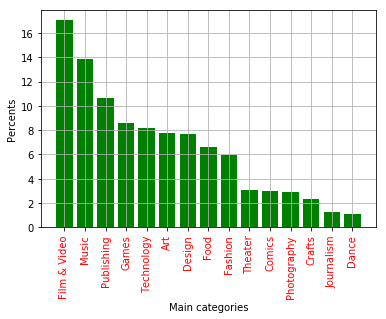

In [131]:
plt.bar(cat_success.index, cat_success['% of projects'], color = 'g')
plt.xlabel('Main categories')
plt.ylabel('Percents')
plt.xticks(np.arange(15), cat_success.index, rotation=90, color = 'r')
plt.grid(True)
#don't know  how to remove <matplotlib.axis.XTick at 0x7f37e18926d8> these..:(

In [132]:
df_country = success_rate(df, 'country')
df_country
#lets look at to 5 countrys by projects quentity

,% of projects,count
US,78.85,261358
GB,8.89,29453
CA,3.73,12370
AU,2.00,6616
DE,1.04,3436
FR,0.76,2520
NL,0.73,2411
IT,0.71,2369
ES,0.57,1873
SE,0.46,1509


In [ ]:
df.drop(index)

In [133]:
df.head()

,name,category,main_category,deadline,goal,launched,state,country
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,1533.95,2015-08-11 12:12:28,failed,GB
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,30000.00,2017-09-02 04:43:57,failed,US
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,45000.00,2013-01-12 00:20:50,failed,US
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,5000.00,2012-03-17 03:24:11,failed,US
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,50000.00,2016-02-26 13:38:27,successful,US


In [134]:
df_country.iloc[0, 1]
country_success_dic = {}

In [135]:
hist_indicator = 'success'
hist_country = 'US'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

us_success = df[mask1 & mask2]
us_success_percent = round(len(us_success)/df_country.iloc[0, 1]*100, 2)
country_success_dic['US'] = us_success_percent
us_success_percent


41.82

In [136]:
hist_indicator = 'success'
hist_country = 'GB'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

gb_success = df[mask1 & mask2]
gb_success_percent = round(len(gb_success)/df_country.iloc[1, 1]*100, 2)
country_success_dic['GB'] = gb_success_percent
gb_success_percent

40.97

In [137]:
hist_indicator = 'success'
hist_country = 'CA'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

ca_success = df[mask1 & mask2]
ca_success_percent = round(len(ca_success)/df_country.iloc[2, 1]*100, 2)
country_success_dic['CA'] = ca_success_percent
ca_success_percent

33.42

In [138]:
hist_indicator = 'success'
hist_country = 'AU'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

au_success = df[mask1 & mask2]
au_success_percent = round(len(au_success)/df_country.iloc[3, 1]*100, 2)
country_success_dic['AU'] = au_success_percent
au_success_percent

30.38

In [139]:
hist_indicator = 'success'
hist_country = 'DE'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

de_success = df[mask1 & mask2]
de_success_percent = round(len(de_success)/df_country.iloc[4, 1]*100, 2)
country_success_dic['DE'] = de_success_percent
de_success_percent

27.27

In [140]:
print(country_success_dic)

{'US': 41.82, 'GB': 40.97, 'CA': 33.42, 'AU': 30.38, 'DE': 27.27}


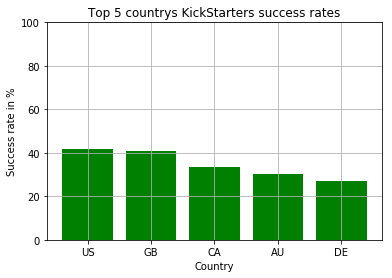

In [141]:
plt.bar(country_success_dic.keys(), country_success_dic.values(), color = 'g')
plt.ylim(0, 100)#Make Y axis 100% insted of 40%
plt.xlabel('Country')
plt.ylabel('Success rate in %')
plt.title('Top 5 countrys KickStarters success rates')
plt.grid(True)

In [142]:
print(df.iloc[:1]['state'].values == 'failed')

[ True]


In [143]:
st_US = 'US'
st_GB = 'GB'
st_CA = 'CA'
st_AU = 'AU'
st_DE = 'DE'
mask1 = df['country'].str.contains(st_US)
mask2 = df['country'].str.contains(st_GB)
mask3 = df['country'].str.contains(st_CA)
mask4 = df['country'].str.contains(st_AU)
mask5 = df['country'].str.contains(st_DE)
df_main_countrys = df.any(mask1, mask2, mask3, mask4, mask5)
df_main_countrys

TypeError: logical_func() takes from 1 to 5 positional arguments but 6 were given

In [174]:
def success_rate (df, state):
    x = pd.concat([df[state].value_counts(normalize = True) * 100,
    #normalize = True --> returns count devided by 374860(vhole df)
                  df[state].value_counts(normalize = False)], axis = 1)
    x = round(x, 2) #round up numbers
    #axis = 1 --> conacatinating columns
    x.columns = ['% of projects', 'count']
    return x

In [175]:
money_goal = success_rate(df, 'goal').head(15)
money_goal

,% of projects,count
5000.0,7.95,27117
10000.0,6.93,23621
1000.0,4.61,15714
3000.0,4.21,14344
2000.0,4.06,13863
15000.0,3.77,12857
20000.0,3.40,11584
2500.0,3.23,11022
500.0,3.17,10823
1500.0,2.77,9454


In [ ]:
sort_success = sorted(list(money_goal['count']), reverse = False)


In [ ]:
plt.hist(np.log1p(money_goal.index), bins = 15, log=False)
plt.xlabel('Money goal')
plt.ylabel('Probability density')
# plt.xticks()
# plt.yticks()
plt.grid(True)

In [ ]:
count = money_goal.index.values
percent = money_goal['% of projects'].values
#plt.hist(money_goal['count'])
plt.bar(percent, count)
plt.grid(True)
plt.xlabel(money_goal['count'].iloc[0])

In [ ]:
df.goal.describe()

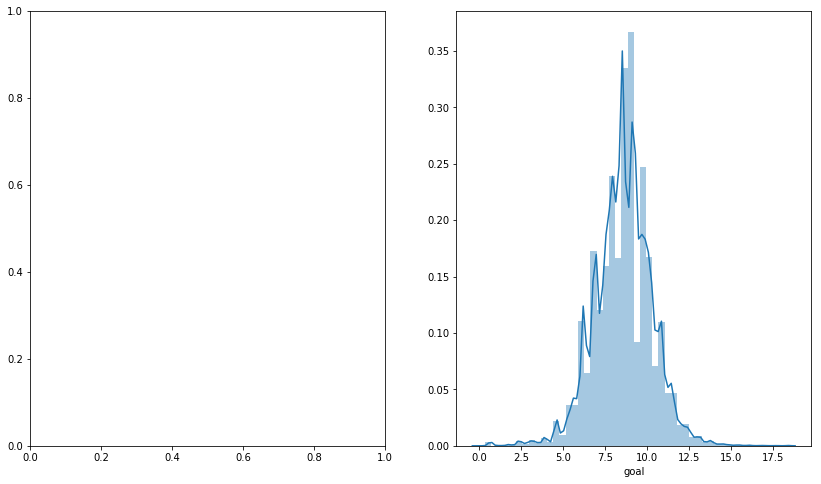

In [173]:
# combine different plots into one: goal and log(goal)
dims = (14, 8)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=dims)
#sns.distplot(df.goal, ax=ax1)
sns.distplot(np.log1p(df.goal), ax=ax2)

In [ ]:
#convert launched and deadline to real date
df['lounched'] = pd.to_datetime(df.launched)
df['deadline'] = pd.to_datetime(df.deadline)
df = df.sort_values('launched')

In [ ]:
df.head()

In [170]:
df.query("country in ['US', 'GB', 'CA']", inplace = True)

In [171]:
df.shape

(341055, 15)

In [172]:
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00
